In [12]:
import sys
from pathlib import Path

root_dir = Path.cwd().parent  # Go one folder up from /notebooks
print("Root directory:", root_dir)

if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))
    
import pandas as pd
df = pd.read_parquet("../data/ml/financials_annual_th_ohlcv_clean.parquet")
print(df.shape)

Root directory: /Users/agalyaayyadurai/Automated-Equity-Valuation
(7467, 87)


In [13]:
import numpy as np
import pandas as pd

def prepare_ml_dataset(df: pd.DataFrame):
    df = df.copy()

    # 1. Target: log market cap = log(close * shares)
    df["market_cap"] = df["close"] * df["CommonSharesOutstanding"]

    # Ensure only positive market caps are logged
    df["market_cap"] = df["market_cap"].where(df["market_cap"] > 0, np.nan)
    df["log_market_cap"] = np.log(df["market_cap"])

    target_name = "log_market_cap"
    y = df[target_name]

    # 2. Helpers
    def safe_div(num, denom):
        return np.where(
            (denom == 0) | np.isnan(denom),
            np.nan,
            num / denom
        )

    def signed_log1p(x):
        return np.sign(x) * np.log1p(np.abs(x))

    # 3. Basic logs (scale handling) – non-negative columns
    nonneg_log_cols = [
        "Revenue", "TotalAssets", "TotalLiabilities",
        "ShareholdersEquity", "TotalCurrentAssets",
        "TotalCurrentLiabilities", "CashAndCashEquivalents",
        "PPandE", "CommonSharesOutstanding", "market_cap"
    ]
    for col in nonneg_log_cols:
        if col in df.columns:
            s = df[col].where(df[col] > 0, np.nan)
            df[f"log_{col}"] = np.log(s)

    # Can be negative: use signed log
    signed_log_cols = [
        "OperatingIncome", "NetIncome", "CFO", "CFI", "CFF",
        "CapEx", "DepAmortCF", "StockBasedComp"
    ]
    for col in signed_log_cols:
        if col in df.columns:
            df[f"slog_{col}"] = signed_log1p(df[col])

    # 4. Time features
    df["fiscal_year"] = df["period"].dt.year
    df["filing_year"] = df["filed"].dt.year
    df["filing_month"] = df["filed"].dt.month

    # price_date can have NaNs; be robust
    if "price_date" in df.columns:
        df["delay_days"] = (
            df["price_date"].dt.normalize() - df["filed"].dt.normalize()
        ).dt.days
    else:
        df["delay_days"] = np.nan

    # 5. Per-share features
    shares = df["CommonSharesOutstanding"]
    df["revenue_per_share"] = safe_div(df["Revenue"], shares)
    df["eps"] = safe_div(df["NetIncome"], shares)
    df["book_value_per_share"] = safe_div(df["ShareholdersEquity"], shares)
    df["cfo_per_share"] = safe_div(df["CFO"], shares)

    # 6. Margins & profitability
    revenue = df["Revenue"]
    assets = df["TotalAssets"]
    equity = df["ShareholdersEquity"]

    df["gross_margin"]   = safe_div(df["GrossProfit"], revenue)
    df["operating_margin"] = safe_div(df["OperatingIncome"], revenue)
    df["net_margin"]     = safe_div(df["NetIncome"], revenue)

    df["roa"] = safe_div(df["NetIncome"], assets)
    df["roe"] = safe_div(df["NetIncome"], equity)
    df["cfo_margin"] = safe_div(df["CFO"], revenue)
    df["cfo_to_net_income"] = safe_div(df["CFO"], df["NetIncome"])

    # 7. Leverage & liquidity
    long_debt  = df["LongTermDebt"].fillna(0)    if "LongTermDebt" in df.columns else 0
    short_debt = df["ShortTermDebt"].fillna(0)   if "ShortTermDebt" in df.columns else 0
    total_debt = long_debt + short_debt
    df["total_debt"] = total_debt

    curr_assets = df["TotalCurrentAssets"]
    curr_liab   = df["TotalCurrentLiabilities"]
    inventory   = df["Inventory"]

    df["debt_to_equity"] = safe_div(total_debt, equity)
    df["debt_to_assets"] = safe_div(total_debt, assets)
    df["current_ratio"]  = safe_div(curr_assets, curr_liab)
    df["quick_ratio"]    = safe_div(curr_assets - inventory, curr_liab)
    df["cash_ratio"]     = safe_div(df["CashAndCashEquivalents"], curr_liab)
    df["cash_to_assets"] = safe_div(df["CashAndCashEquivalents"], assets)

    # 8. Cash flow & investment
    df["capex_to_revenue"] = safe_div(df["CapEx"], revenue)
    df["capex_to_assets"]  = safe_div(df["CapEx"], assets)
    df["cfo_to_assets"]    = safe_div(df["CFO"], assets)

    df["fcf_approx"]      = df["CFO"] + df["CapEx"]
    df["fcf_per_share"]   = safe_div(df["fcf_approx"], shares)
    df["fcf_to_revenue"]  = safe_div(df["fcf_approx"], revenue)

    if "RND" in df.columns:
        df["rnd_to_revenue"] = safe_div(df["RND"], revenue)
        df["rnd_to_assets"]  = safe_div(df["RND"], assets)
    if "SGA" in df.columns:
        df["sga_to_revenue"] = safe_div(df["SGA"], revenue)
        df["sga_to_assets"]  = safe_div(df["SGA"], assets)

    # 9. Raw fundamentals to consider as features
    raw_fundamentals = [
        "Revenue", "GrossProfit", "OperatingIncome", "NetIncome",
        "OperatingExpenses", "CostOfRevenue",
        "TotalAssets", "TotalLiabilities", "ShareholdersEquity",
        "TotalCurrentAssets", "TotalCurrentLiabilities",
        "CashAndCashEquivalents", "AccountsReceivable", "Inventory",
        "PPandE", "LongTermDebt", "ShortTermDebt",
        "OtherCurrentLiabilities", "OtherNoncurrentLiabilities",
        "CFO", "CFI", "CFF", "CapEx", "DepAmortCF",
        "StockBasedComp", "RND", "SGA"
    ]
    raw_fundamentals = [c for c in raw_fundamentals if c in df.columns]

    # 10. Engineered numeric features
    engineered_cols = [c for c in df.columns
                       if c.startswith("log_") or c.startswith("slog_")]

    engineered_cols += [
        "revenue_per_share", "eps", "book_value_per_share", "cfo_per_share",
        "gross_margin", "operating_margin", "net_margin",
        "roa", "roe", "cfo_margin", "cfo_to_net_income",
        "total_debt", "debt_to_equity", "debt_to_assets",
        "current_ratio", "quick_ratio", "cash_ratio", "cash_to_assets",
        "capex_to_revenue", "capex_to_assets", "cfo_to_assets",
        "fcf_approx", "fcf_per_share", "fcf_to_revenue",
        "rnd_to_revenue", "rnd_to_assets",
        "sga_to_revenue", "sga_to_assets",
        "fiscal_year", "filing_year", "filing_month", "delay_days"
    ]
    engineered_cols = [c for c in engineered_cols if c in df.columns]

    # De-duplicate engineered_cols
    seen = set()
    engineered_cols = [c for c in engineered_cols if not (c in seen or seen.add(c))]

    # 11. Categorical columns
    categorical_cols = []
    for c in ["office", "industry_title"]:
        if c in df.columns:
            categorical_cols.append(c)

    # 12. Exclude identifiers / target / dates from X
    exclude_cols = {
        "adsh", "cik", "ticker", "name", "form",
        "period", "filed", "accepted", "instance",
        "price_date", "market_cap", "log_market_cap"
    }

    feature_cols = [c for c in (raw_fundamentals + engineered_cols + categorical_cols)
                    if c not in exclude_cols]

    X = df[feature_cols]

    meta = {
        "feature_names": feature_cols,
        "categorical_cols": categorical_cols,
        "target_name": target_name,
        "df_with_features": df
    }

    return X, y, meta


In [14]:
X, y, meta = prepare_ml_dataset(df)

## Simple Linear Regression Model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# 1) Drop rows where TARGET is NaN (just in case)
mask = y.notna()
X_clean = X[mask]
y_clean = y[mask]

# 2) Train/test split (random here; later you can swap for time-based)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# 3) Define numeric & categorical columns
categorical_cols = meta.get("categorical_cols", ["office", "industry_title"])
categorical_cols = [c for c in categorical_cols if c in X_clean.columns]

numeric_cols = [c for c in X_clean.columns if c not in categorical_cols]

# 4) Preprocess: numeric + categorical pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# 5) Full pipeline: preprocess -> linear regression
lin_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

# 6) Fit & evaluate
lin_pipe.fit(X_train, y_train)
y_pred_lin = lin_pipe.predict(X_test)

print("Linear Regression:")
print("  RMSE:", mean_squared_error(y_test, y_pred_lin, squared=False))
print("  MAE :", mean_absolute_error(y_test, y_pred_lin))
print("  R²  :", r2_score(y_test, y_pred_lin))

Linear Regression:
  RMSE: 2.3256250830017784
  MAE : 1.4146759132919486
  R²  : 0.47074651609938645


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Gradient Boosting

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor

# 1) Drop rows where TARGET is NaN (just in case)
mask = y.notna()
X_clean = X[mask]
y_clean = y[mask]

# 2) Random train/test split (you can replace with time-based later)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# 3) Identify categorical & numeric columns
categorical_cols = meta.get("categorical_cols", ["office", "industry_title"])
categorical_cols = [c for c in categorical_cols if c in X_clean.columns]

numeric_cols = [c for c in X_clean.columns if c not in categorical_cols]

# 4) Preprocessor: OneHotEncode categoricals, passthrough numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

# 5) Full Gradient Boosting pipeline
gb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.03,
        max_iter=500,
        l2_regularization=1.0
    ))
])

# 6) Fit & evaluate
gb_pipe.fit(X_train, y_train)
y_pred_gb = gb_pipe.predict(X_test)

print("Gradient Boosting (with categoricals):")
print("  RMSE:", mean_squared_error(y_test, y_pred_gb, squared=False))
print("  MAE :", mean_absolute_error(y_test, y_pred_gb))
print("  R²  :", r2_score(y_test, y_pred_gb))

Gradient Boosting (with categoricals):
  RMSE: 1.9128975899120437
  MAE : 1.1227802433818574
  R²  : 0.6419301455196884


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Time base trian validation test

In [15]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Base data from meta ---
df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year
df_feat = df_feat.sort_values("year")

X_full = df_feat[meta["feature_names"]]
y_full = df_feat[meta["target_name"]]

# --- Time-based masks ---
train_mask = df_feat["year"] <= 2018
val_mask   = (df_feat["year"] >= 2019) & (df_feat["year"] <= 2021)
test_mask  = df_feat["year"] >= 2022

X_train, y_train = X_full[train_mask], y_full[train_mask]
X_val,   y_val   = X_full[val_mask],   y_full[val_mask]
X_test,  y_test  = X_full[test_mask],  y_full[test_mask]   # keep aside for later

# Drop rows where target is NaN (just in case)
train_mask_valid = y_train.notna()
X_train, y_train = X_train[train_mask_valid], y_train[train_mask_valid]

val_mask_valid = y_val.notna()
X_val, y_val   = X_val[val_mask_valid], y_val[val_mask_valid]

In [16]:
# numeric categorical columns
categorical_cols = meta.get("categorical_cols", ["office", "industry_title"])
categorical_cols = [c for c in categorical_cols if c in X_full.columns]

numeric_cols = [c for c in X_full.columns if c not in categorical_cols]


### Linear REg

In [17]:
# ----- Linear Regression pipeline -----
numeric_transformer_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_lin = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lin, numeric_cols),
        ("cat", categorical_transformer_lin, categorical_cols),
    ]
)

lin_pipe = Pipeline(steps=[
    ("preprocess", preprocess_lin),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
y_pred_val_lin = lin_pipe.predict(X_val)

print("LINEAR REGRESSION (VALIDATION)")
print("  R²  :", r2_score(y_val, y_pred_val_lin))
print("  RMSE:", mean_squared_error(y_val, y_pred_val_lin, squared=False))
print("  MAE :", mean_absolute_error(y_val, y_pred_val_lin))


LINEAR REGRESSION (VALIDATION)
  R²  : 0.19398401844133717
  RMSE: 2.634266136812639
  MAE : 1.6883794626383446


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


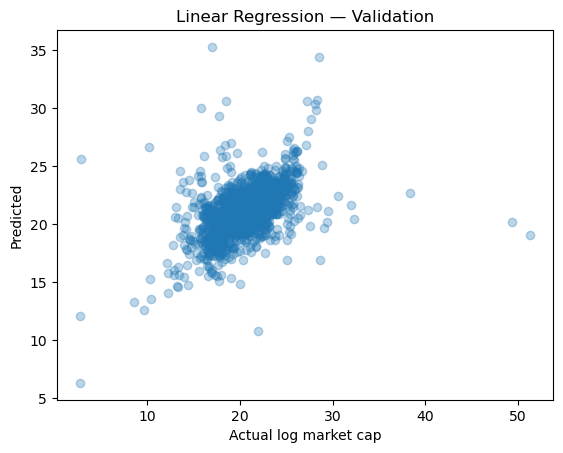

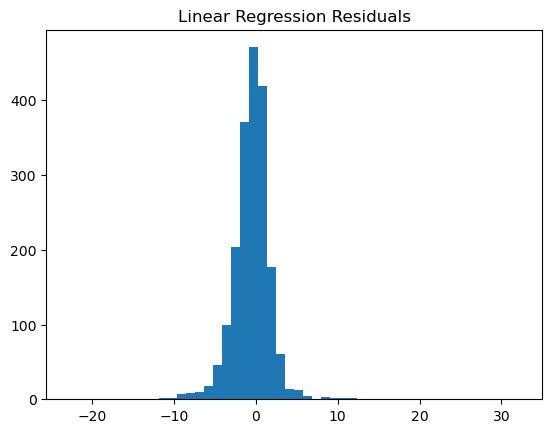

In [19]:
import matplotlib.pyplot as plt
plt.scatter(y_val, y_pred_val_lin, alpha=0.3)
plt.xlabel("Actual log market cap")
plt.ylabel("Predicted")
plt.title("Linear Regression — Validation")
plt.show()

plt.hist(y_val - y_pred_val_lin, bins=50)
plt.title("Linear Regression Residuals")
plt.show()

### Gradient Boosting

In [20]:
# ----- Gradient Boosting pipeline -----
categorical_transformer_gb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess_gb = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer_gb, categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

gb_pipe = Pipeline(steps=[
    ("preprocess", preprocess_gb),
    ("model", HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.03,
        max_iter=500,
        l2_regularization=1.0
    ))
])

gb_pipe.fit(X_train, y_train)
y_pred_val_gb = gb_pipe.predict(X_val)

print("\nGRADIENT BOOSTING (VALIDATION)")
print("  R²  :", r2_score(y_val, y_pred_val_gb))
print("  RMSE:", mean_squared_error(y_val, y_pred_val_gb, squared=False))
print("  MAE :", mean_absolute_error(y_val, y_pred_val_gb))


GRADIENT BOOSTING (VALIDATION)
  R²  : 0.4950730711664023
  RMSE: 2.084980939933049
  MAE : 1.3342518446901257


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


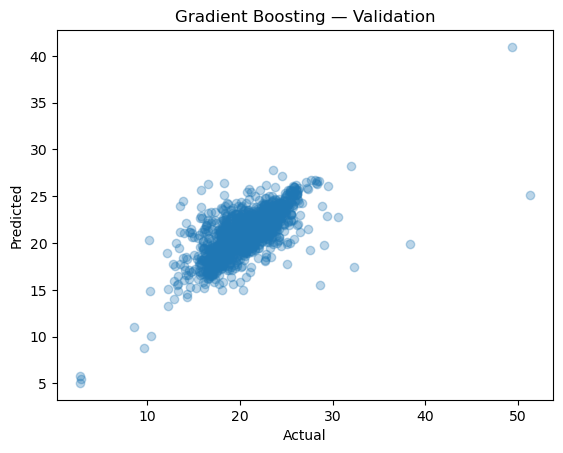

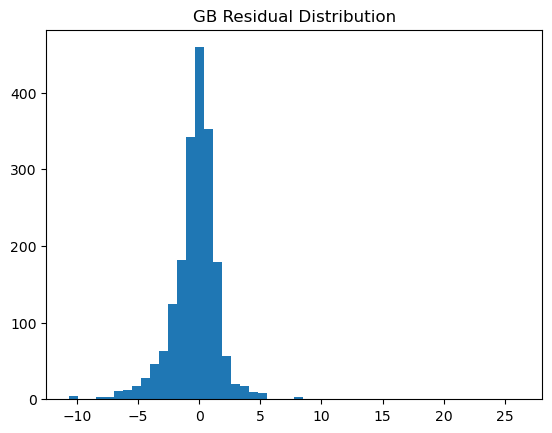

In [21]:
plt.scatter(y_val, y_pred_val_gb, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Gradient Boosting — Validation")
plt.show()

plt.hist(y_val - y_pred_val_gb, bins=50)
plt.title("GB Residual Distribution")
plt.show()

### Getting  the Resiuals from GB model - overvalued nad undervalued equities for each year

In [22]:
val_df = df_feat[val_mask].copy()

val_df["predicted_log_mcap"] = y_pred_val_gb
val_df["residual"] = val_df[meta["target_name"]] - val_df["predicted_log_mcap"]

for yr in [2019, 2020, 2021]:
    print("\n========================")
    print(f"YEAR: {yr}")
    print("========================")
    
    sub = val_df[val_df["year"] == yr].copy()
    
    # UNDERVALUE (most negative residuals)
    print("\nTop 5 Undervalued:")
    print(sub.nsmallest(5, "residual")[["cik", "name", "period", 
                                        meta["target_name"], 
                                        "predicted_log_mcap", 
                                        "residual"]])
    
    # OVERVALUED (most positive residuals)
    print("\nTop 5 Overvalued:")
    print(sub.nlargest(5, "residual")[["cik", "name", "period", 
                                       meta["target_name"], 
                                       "predicted_log_mcap", 
                                       "residual"]])


YEAR: 2019

Top 5 Undervalued:
          cik                         name     period  log_market_cap  \
3700  1281984    SOCIAL LIFE NETWORK, INC. 2019-12-31       10.245496   
279     72444                 VAXART, INC. 2019-12-31       18.279797   
4426  1386049        BEYOND COMMERCE, INC. 2019-12-31       14.217640   
5396  1515740       PREMIER BIOMEDICAL INC 2019-12-31       13.118379   
5491  1528172  ENDONOVO THERAPEUTICS, INC. 2019-12-31       12.091675   

      predicted_log_mcap   residual  
3700           20.281817 -10.036320  
279            26.406609  -8.126812  
4426           22.150402  -7.932762  
5396           20.026251  -6.907872  
5491           18.894233  -6.802558  

Top 5 Overvalued:
          cik                            name     period  log_market_cap  \
2713  1068689   DATA443 RISK MITIGATION, INC. 2019-12-31       28.657214   
5255  1499961               NET ELEMENT, INC. 2019-12-31       49.296969   
1979   946486  WINDTREE THERAPEUTICS INC /DE/ 2019-12-

### RandomForestRegressor

RANDOM FOREST (VALIDATION)
  R²  : 0.4765477217057251
  RMSE: 2.122884518018136
  MAE : 1.3397790384072688


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


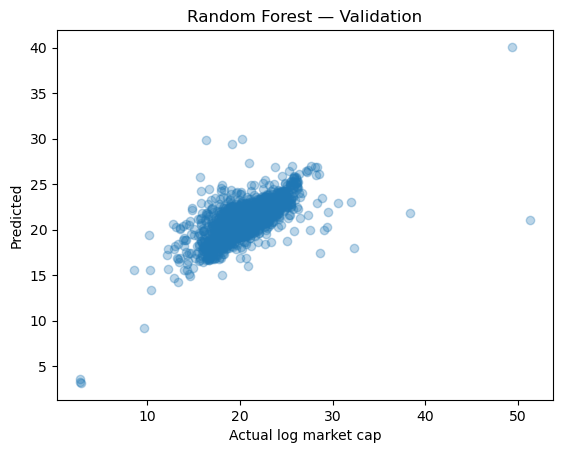

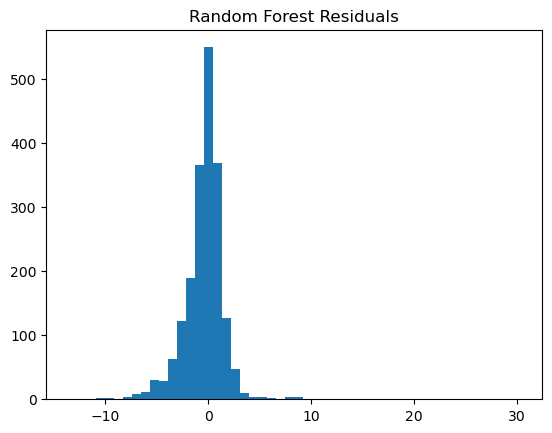

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# ----- Random Forest pipeline -----
# Trees don't need scaling, just imputation.

numeric_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_cols),
        ("cat", categorical_transformer_rf, categorical_cols),
    ]
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess_rf),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,       # or something like 10–20 if you want to regularise
        n_jobs=-1,
        random_state=42
    ))
])

# Fit on training set
rf_pipe.fit(X_train, y_train)

# Predict on validation set
y_pred_val_rf = rf_pipe.predict(X_val)

print("RANDOM FOREST (VALIDATION)")
print("  R²  :", r2_score(y_val, y_pred_val_rf))
print("  RMSE:", mean_squared_error(y_val, y_pred_val_rf, squared=False))
print("  MAE :", mean_absolute_error(y_val, y_pred_val_rf))

# ---- Visuals ----
# 1) Predicted vs Actual scatter
plt.scatter(y_val, y_pred_val_rf, alpha=0.3)
plt.xlabel("Actual log market cap")
plt.ylabel("Predicted")
plt.title("Random Forest — Validation")
plt.show()

# 2) Residual distribution
plt.hist(y_val - y_pred_val_rf, bins=50)
plt.title("Random Forest Residuals")
plt.show()

## Residuals

In [24]:
# Build validation dataframe aligned with X_val / y_val
# df_feat is meta["df_with_features"] with the original indices
val_df = df_feat.loc[X_val.index].copy()

target_col = meta["target_name"]  # e.g. "log_market_cap"

# Add actual target
val_df["actual_log_mcap"] = y_val

# Add predictions
val_df["pred_lin"] = y_pred_val_lin
val_df["pred_rf"]  = y_pred_val_rf
val_df["pred_gb"]  = y_pred_val_gb

# Add residuals: actual - predicted
val_df["resid_lin"] = val_df["actual_log_mcap"] - val_df["pred_lin"]
val_df["resid_rf"]  = val_df["actual_log_mcap"] - val_df["pred_rf"]
val_df["resid_gb"]  = val_df["actual_log_mcap"] - val_df["pred_gb"]

# (Optional) quick sanity peek
val_df[["cik", "name", "period",
        "actual_log_mcap", "pred_lin", "resid_lin",
        "pred_rf", "resid_rf",
        "pred_gb", "resid_gb"]].head()

,cik,name,period,actual_log_mcap,pred_lin,resid_lin,pred_rf,resid_rf,pred_gb,resid_gb
6487,1666071,"CARDLYTICS, INC.",2019-12-31,21.093545,20.867188,0.226358,19.676199,1.417346,19.798302,1.295243
6433,1659323,ITERUM THERAPEUTICS PLC,2019-12-31,19.875163,21.690186,-1.815023,22.638016,-2.762853,22.165808,-2.290646
4274,1368365,"REMARK HOLDINGS, INC.",2019-12-31,20.930629,21.350098,-0.419469,27.275205,-6.344576,25.719565,-4.788936
4356,1375365,"SUPER MICRO COMPUTER, INC.",2019-06-30,18.655187,20.962646,-2.307460,20.837070,-2.181883,21.087613,-2.432427
985,810509,"NAVIDEA BIOPHARMACEUTICALS, INC.",2019-12-31,16.530168,20.867188,-4.337019,21.663902,-5.133734,20.515541,-3.985373


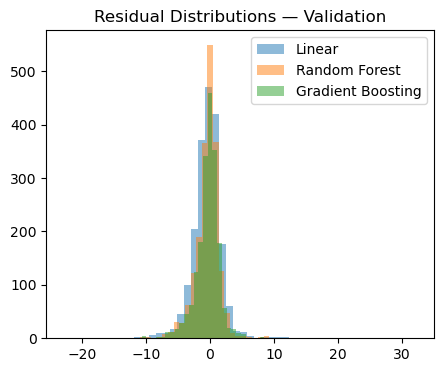

In [25]:
plt.figure(figsize=(5,4))
plt.hist(val_df["resid_lin"], bins=50, alpha=0.5, label="Linear")
plt.hist(val_df["resid_rf"],  bins=50, alpha=0.5, label="Random Forest")
plt.hist(val_df["resid_gb"],  bins=50, alpha=0.5, label="Gradient Boosting")
plt.legend()
plt.title("Residual Distributions — Validation")
plt.show()

## Overvalued/Undervalued?

In [39]:
validation_years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]

In [40]:
def get_top_residuals_by_year(df, model_resid_col, year, top_n=2):
    """
    df: validation dataframe (val_df)
    model_resid_col: e.g. 'resid_gb', 'resid_rf', 'resid_lin'
    """
    df_year = df[df["period"].dt.year == year].copy()
    df_year = df_year.dropna(subset=[model_resid_col, "close"])

    if df_year.empty:
        return None, None

    # UNDERVALUE: most negative residuals → nsmallest
    undervalued = df_year.nsmallest(top_n, model_resid_col)

    # OVERVALUE: most positive residuals → nlargest
    overvalued = df_year.nlargest(top_n, model_resid_col)

    return undervalued, overvalued

In [41]:
import numpy as np
import pandas as pd

initial_capital = 1_000_000

def run_portfolio_simulation(val_df, validation_years, model_resid_col):
    portfolio_value = initial_capital
    history = []

    for year in validation_years:
        undervalued, overvalued = get_top_residuals_by_year(
            val_df, model_resid_col, year, top_n=2
        )

        if undervalued is None:
            print(f"No data for year {year}")
            continue

        # Reset index so we can index arrays with 0,1
        undervalued = undervalued.reset_index(drop=True)
        overvalued = overvalued.reset_index(drop=True)

        # Entry prices at year t
        enter_prices_long  = undervalued["close"].values.astype(float)
        enter_prices_short = overvalued["close"].values.astype(float)

        # Default exit prices = same as entry (if no next-year data, P&L=0)
        exit_prices_long  = enter_prices_long.copy()
        exit_prices_short = enter_prices_short.copy()

        # Next year prices (year + 1)
        next_year_df = val_df[val_df["period"].dt.year == year + 1]
        next_year_df = next_year_df.dropna(subset=["close"])

        # Map cik → next_year_close (first occurrence)
        cik_to_next_close = (
            next_year_df.drop_duplicates("cik")
                        .set_index("cik")["close"]
                        .to_dict()
        )

        # Update exit prices for longs if we have next-year data
        for pos, row in undervalued.iterrows():
            cik = row["cik"]
            if cik in cik_to_next_close:
                exit_prices_long[pos] = cik_to_next_close[cik]

        # Update exit prices for shorts if we have next-year data
        for pos, row in overvalued.iterrows():
            cik = row["cik"]
            if cik in cik_to_next_close:
                exit_prices_short[pos] = cik_to_next_close[cik]

        # Allocation: 50% long, 50% short, equal within each side
        long_alloc_each  = portfolio_value * 0.5 / len(enter_prices_long)
        short_alloc_each = portfolio_value * 0.5 / len(enter_prices_short)

        # Shares
        long_shares  = long_alloc_each  / enter_prices_long
        short_shares = short_alloc_each / enter_prices_short

        # P&L: longs = (exit - entry), shorts = (entry - exit)
        pnl_long  = np.sum(long_shares  * (exit_prices_long  - enter_prices_long))
        pnl_short = np.sum(short_shares * (enter_prices_short - exit_prices_short))

        year_pnl = pnl_long + pnl_short
        portfolio_value = portfolio_value + year_pnl

        history.append({
            "year": year,
            "long_picks":  list(undervalued["ticker"]),
            "short_picks": list(overvalued["ticker"]),
            "pnl": float(year_pnl),
            "portfolio_value": float(portfolio_value),
        })

    return pd.DataFrame(history)

In [42]:
validation_years = [2019, 2020]

history_lin = run_portfolio_simulation(val_df, validation_years, "resid_lin")
history_rf  = run_portfolio_simulation(val_df, validation_years, "resid_rf")
history_gb  = run_portfolio_simulation(val_df, validation_years, "resid_gb")

print("\n=== Linear Regression Portfolio ===")
print(history_lin)

print("\n=== Random Forest Portfolio ===")
print(history_rf)

print("\n=== Gradient Boosting Portfolio (Primary) ===")
print(history_gb)

No data for year 2022
No data for year 2023
No data for year 2024
No data for year 2025
No data for year 2022
No data for year 2023
No data for year 2024
No data for year 2025
No data for year 2022
No data for year 2023
No data for year 2024
No data for year 2025

=== Linear Regression Portfolio ===
   year    long_picks   short_picks           pnl  portfolio_value
0  2019  [WDLF, BYOC]  [BINI, ATDS]  1.255606e+07     1.355606e+07
1  2020  [CGLO, TTCM]  [BINI, ATDS]  3.258389e+06     1.681445e+07
2  2021  [CTDD, ENZN]  [ADTX, APVO]  0.000000e+00     1.681445e+07

=== Random Forest Portfolio ===
   year     long_picks   short_picks           pnl  portfolio_value
0  2019   [ATYR, WDLF]  [ATDS, BINI]  1.235220e+07     1.335220e+07
1  2020  [DBVTF, WEWA]  [BINI, ATDS]  3.209389e+06     1.656159e+07
2  2021  [XOMAO, ALDS]  [ADTX, APVO]  0.000000e+00     1.656159e+07

=== Gradient Boosting Portfolio (Primary) ===
   year    long_picks   short_picks           pnl  portfolio_value
0  2019  [WD

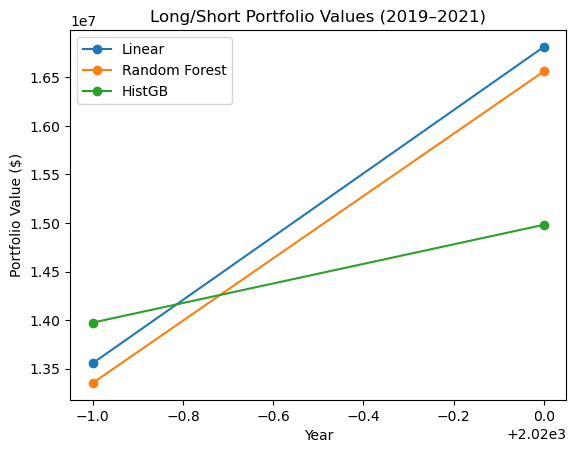

In [30]:
import matplotlib.pyplot as plt

plt.plot(history_lin["year"], history_lin["portfolio_value"], marker="o", label="Linear")
plt.plot(history_rf["year"],  history_rf["portfolio_value"], marker="o", label="Random Forest")
plt.plot(history_gb["year"],  history_gb["portfolio_value"], marker="o", label="HistGB")

plt.legend()
plt.title("Long/Short Portfolio Values (2019–2021)")
plt.xlabel("Year")
plt.ylabel("Portfolio Value ($)")
plt.show()


## Large Cap Universe Portfolio

In [31]:
import numpy as np
import pandas as pd

# ================================
# 1. Start from full feature df
# ================================
df_feat = meta["df_with_features"].copy()

# Market cap at price_date (close * shares)
df_feat["mcap"] = df_feat["close"] * df_feat["CommonSharesOutstanding"]

# Large-cap filter: > 300M
mcap_threshold = 300_000_000
df_large = df_feat[df_feat["mcap"] > mcap_threshold].copy()

# Add filing year
df_large["year"] = df_large["period"].dt.year

# ================================
# 2. STAR logic inside large-cap universe
# ================================
required_years = set(range(2014, 2025))   # full history condition
pnl_years      = {2019, 2020, 2021}       # years needed for entry/exit

# Years where company exists in large-cap universe
years_all = (
    df_large.groupby("cik")["year"]
            .agg(lambda s: set(s))
)

# Years where company has price in large-cap universe
years_price = (
    df_large.dropna(subset=["close"])
            .groupby("cik")["year"]
            .agg(lambda s: set(s))
)

# Align indices
all_index = years_all.index.union(years_price.index)
years_all   = years_all.reindex(all_index, fill_value=set())
years_price = years_price.reindex(all_index, fill_value=set())

def is_star(cik):
    yrs_all   = years_all.loc[cik]
    yrs_price = years_price.loc[cik]
    has_full_hist   = required_years.issubset(yrs_all)
    has_all_pnl_yrs = pnl_years.issubset(yrs_price)
    return has_full_hist and has_all_pnl_yrs

star_mask = pd.Series(all_index).apply(is_star)
star_mask.index = all_index

star_df = star_mask.astype(int).rename("star").to_frame()

# Make cik explicit as a column for merging
star_df = star_df.reset_index().rename(columns={"index": "cik"})

print("Number of STAR large-cap companies:", int(star_df["star"].sum()))

# ================================
# 3. Build validation LARGE-CAP + STAR dataframe
# ================================
# First ensure validation df has mcap too (for info / further filtering)
val_df = val_df.copy()
val_df["mcap"] = val_df["close"] * val_df["CommonSharesOutstanding"]

# Merge STAR info onto validation df
val_df_large = val_df.merge(star_df, on="cik", how="left")

# Non-large-cap / non-STAR companies will have NaN star → set to 0
val_df_large["star"] = val_df_large["star"].fillna(0).astype(int)

# Keep ONLY large-cap STAR rows: star=1 and mcap>threshold
val_df_large_star = val_df_large[
    (val_df_large["star"] == 1) &
    (val_df_large["mcap"] > mcap_threshold)
].copy()

print("Validation rows (large-cap STAR only):", len(val_df_large_star))
print("Unique large-cap STAR ciks in validation:", val_df_large_star["cik"].nunique())
print(val_df_large_star[["cik", "ticker", "name"]].drop_duplicates().head())

# ================================
# 4. Run STAR-only portfolios for all 3 models
# ================================
validation_years = [2019, 2020]

history_lin_star = run_portfolio_simulation(val_df_large_star, validation_years, "resid_lin")
history_rf_star  = run_portfolio_simulation(val_df_large_star, validation_years, "resid_rf")
history_gb_star  = run_portfolio_simulation(val_df_large_star, validation_years, "resid_gb")

print("\n=== LARGE-CAP STAR ONLY — Linear Regression Portfolio ===")
print(history_lin_star)

print("\n=== LARGE-CAP STAR ONLY — Random Forest Portfolio ===")
print(history_rf_star)

print("\n=== LARGE-CAP STAR ONLY — Gradient Boosting Portfolio (Primary) ===")
print(history_gb_star)

Number of STAR large-cap companies: 94
Validation rows (large-cap STAR only): 282
Unique large-cap STAR ciks in validation: 94
        cik ticker                       name
6    737758    TTC                    TORO CO
7    836157    LNN               LINDSAY CORP
8   1597033   SABR                 SABRE CORP
10  1611983  LBRDB     LIBERTY BROADBAND CORP
26  1142417   NXST  NEXSTAR MEDIA GROUP, INC.

=== LARGE-CAP STAR ONLY — Linear Regression Portfolio ===
   year    long_picks short_picks            pnl  portfolio_value
0  2019  [GILD, CALX]   [EPAM, T]  497087.065479     1.497087e+06
1  2020  [MSFT, SABR]   [T, EPAM]  229603.014850     1.726690e+06

=== LARGE-CAP STAR ONLY — Random Forest Portfolio ===
   year    long_picks   short_picks           pnl  portfolio_value
0  2019  [NVAX, TBPH]  [AMRN, LPSN]  5.053285e+06     6.053285e+06
1  2020   [VRNT, BHC]  [LPSN, AAPL]  2.102550e+06     8.155834e+06

=== LARGE-CAP STAR ONLY — Gradient Boosting Portfolio (Primary) ===
   year    long

## On test set

In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ---------------------------------
# 1. Rebuild test split by YEAR
#    (train <= 2018, val 2019–2021, test >= 2022)
# ---------------------------------

df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year

# Make sure X, y are aligned with df_feat index
X = X.copy()
y = y.copy()

# Define masks
train_mask = df_feat["year"] <= 2018
val_mask   = (df_feat["year"] >= 2019) & (df_feat["year"] <= 2021)
test_mask  = df_feat["year"] >= 2022

# Extract test set
X_test = X.loc[test_mask]
y_test = y.loc[test_mask]
test_df = df_feat.loc[test_mask].copy()

print("Test years present:", sorted(test_df["year"].unique()))
print("Test set size:", len(X_test))

# ---------------------------------
# 2. Evaluate all 3 models on TEST
#    (using existing fitted pipelines: lin_pipe, rf_pipe, gb_pipe)
# ---------------------------------

y_pred_test_lin = lin_pipe.predict(X_test)
y_pred_test_rf  = rf_pipe.predict(X_test)
y_pred_test_gb  = gb_pipe.predict(X_test)

def print_metrics(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"\n{name} (TEST)")
    print("  R²  :", r2)
    print("  RMSE:", rmse)
    print("  MAE :", mae)

print_metrics("Linear Regression", y_test, y_pred_test_lin)
print_metrics("Random Forest",     y_test, y_pred_test_rf)
print_metrics("Gradient Boosting", y_test, y_pred_test_gb)

# ---------------------------------
# 3. Build large-cap test universe and residuals
#    (mcap > 300M, equal-weight long/short strategy)
# ---------------------------------

# Actual log market cap
test_df["actual_log_mcap"] = y_test

# Predictions & residuals
test_df["pred_lin"] = y_pred_test_lin
test_df["pred_rf"]  = y_pred_test_rf
test_df["pred_gb"]  = y_pred_test_gb

test_df["resid_lin"] = test_df["actual_log_mcap"] - test_df["pred_lin"]
test_df["resid_rf"]  = test_df["actual_log_mcap"] - test_df["pred_rf"]
test_df["resid_gb"]  = test_df["actual_log_mcap"] - test_df["pred_gb"]

# Market cap and large-cap filter
test_df["mcap"] = test_df["close"] * test_df["CommonSharesOutstanding"]
mcap_threshold = 300_000_000
test_df_large = test_df[test_df["mcap"] > mcap_threshold].copy()

print("\nLarge-cap test rows:", len(test_df_large))
print("Unique large-cap ciks in test:", test_df_large["cik"].nunique())

# ---------------------------------
# 4. Run portfolio simulation on test years
#    using your existing run_portfolio_simulation()
#    Strategy: top 2 undervalued (long), top 2 overvalued (short) per year
# ---------------------------------

# Decide which test years can be used for trading:
# A year is tradable if we also have data for year+1 (to close the position).
all_test_years = sorted(test_df_large["year"].unique())
trade_years = [yr for yr in all_test_years if (yr + 1) in all_test_years]

print("Test trade years (entry years):", trade_years)

# Example run_portfolio_simulation signature assumed:
# run_portfolio_simulation(df, years, resid_col, initial_value=1_000_000, top_k=2)

history_lin_test = run_portfolio_simulation(test_df_large, trade_years, "resid_lin")
history_rf_test  = run_portfolio_simulation(test_df_large, trade_years, "resid_rf")
history_gb_test  = run_portfolio_simulation(test_df_large, trade_years, "resid_gb")

print("\n=== TEST — Linear Regression Portfolio (Large-cap) ===")
print(history_lin_test)

print("\n=== TEST — Random Forest Portfolio (Large-cap) ===")
print(history_rf_test)

print("\n=== TEST — Gradient Boosting Portfolio (Large-cap, Primary) ===")
print(history_gb_test)

Test years present: [2022, 2023, 2024, 2025]
Test set size: 2467

Linear Regression (TEST)
  R²  : -2.5668791842567004e+18
  RMSE: 4551661433.492995
  MAE : 129598620.80595209

Random Forest (TEST)
  R²  : 0.198712693620533
  RMSE: 2.543087878377334
  MAE : 1.7562187551777841

Gradient Boosting (TEST)
  R²  : 0.2700370935825359
  RMSE: 2.4272674513121975
  MAE : 1.6608390346870043

Large-cap test rows: 1550
Unique large-cap ciks in test: 637
Test trade years (entry years): [2022, 2023, 2024]

=== TEST — Linear Regression Portfolio (Large-cap) ===
   year    long_picks    short_picks            pnl  portfolio_value
0  2022  [AAPL, MSFT]  [ADTX, LFLYD]  471229.002496     1.471229e+06
1  2023   [SYM, AAPL]   [MMCP, BINI]  -68056.512660     1.403172e+06
2  2024   [ALT, MSFT]    [LFLYD, VZ]       0.000000     1.403172e+06

=== TEST — Random Forest Portfolio (Large-cap) ===
   year    long_picks    short_picks            pnl  portfolio_value
0  2022  [IBIO, SEGG]  [ADTX, LFLYD]  373052.98719

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Visual of portoflio growth from 2019 - 2025

In [78]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# =====================================================
# 1) Base data + time-based split
# =====================================================

df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year
df_feat = df_feat.sort_values("year")

X_full = df_feat[meta["feature_names"]]
y_full = df_feat[meta["target_name"]]

# Time-based masks
train_mask = df_feat["year"] <= 2019   # TRAIN: up to 2018
test_mask  = df_feat["year"] >= 2020   # TEST: 2019 onwards (incl. your old val+test)

X_train, y_train = X_full[train_mask], y_full[train_mask]
X_test,  y_test  = X_full[test_mask],  y_full[test_mask]

# Drop rows where target is NaN (safety)
train_valid = y_train.notna()
X_train, y_train = X_train[train_valid], y_train[train_valid]

test_valid = y_test.notna()
X_test,  y_test  = X_test[test_valid],  y_test[test_valid]

print("Train years:", sorted(df_feat.loc[train_mask, "year"].unique()))
print("Test years:", sorted(df_feat.loc[test_mask,  "year"].unique()))
print("Train size:", len(X_train))
print("Test size :", len(X_test))

# =====================================================
# 2) Column types: numeric vs categorical
# =====================================================

# Infer categorical vs numeric from dtypes
categorical_cols = [c for c in X_full.columns if X_full[c].dtype == "object"]
numeric_cols     = [c for c in X_full.columns if c not in categorical_cols]

print("Numeric features   :", len(numeric_cols))
print("Categorical features:", len(categorical_cols))

# =====================================================
# 3) Linear Regression pipeline
#    (impute + scale numerics, one-hot cats)
# =====================================================

numeric_transformer_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_lin = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lin, numeric_cols),
        ("cat", categorical_transformer_lin, categorical_cols),
    ]
)

lin_pipe = Pipeline(steps=[
    ("preprocess", preprocess_lin),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
y_pred_test_lin = lin_pipe.predict(X_test)

# =====================================================
# 4) Random Forest pipeline
#    (impute numerics, one-hot cats, no scaling)
# =====================================================

numeric_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_cols),
        ("cat", categorical_transformer_rf, categorical_cols),
    ]
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess_rf),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)
y_pred_test_rf = rf_pipe.predict(X_test)

# =====================================================
# 5) Gradient Boosting pipeline
#    (HistGradientBoostingRegressor + OneHot for cats)
# =====================================================

categorical_transformer_gb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess_gb = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer_gb, categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

gb_pipe = Pipeline(steps=[
    ("preprocess", preprocess_gb),
    ("model", HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.03,
        max_iter=500,
        l2_regularization=1.0,
        random_state=42
    ))
])

gb_pipe.fit(X_train, y_train)
y_pred_test_gb = gb_pipe.predict(X_test)

# =====================================================
# 6) Metrics helper and TEST results
# =====================================================

def print_metrics(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"\n{name} (TEST 2020+)")
    print("  R²  :", r2)
    print("  RMSE:", rmse)
    print("  MAE :", mae)

print_metrics("Linear Regression", y_test, y_pred_test_lin)
print_metrics("Random Forest",     y_test, y_pred_test_rf)
print_metrics("Gradient Boosting", y_test, y_pred_test_gb)


Train years: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test years: [2020, 2021, 2022, 2023, 2024, 2025]
Train size: 3605
Test size : 3862
Numeric features   : 76
Categorical features: 2

Linear Regression (TEST 2020+)
  R²  : -2.624296526746742e+18
  RMSE: 4601116847.073819
  MAE : 104706135.8596962

Random Forest (TEST 2020+)
  R²  : 0.36443853156107053
  RMSE: 2.2643084618472975
  MAE : 1.4891235699323557

Gradient Boosting (TEST 2020+)
  R²  : 0.482890866320155
  RMSE: 2.042433447706757
  MAE : 1.352954959197598


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [79]:
# df_feat already exists from your first cell and has mcap + year
df_feat["mcap"] = df_feat["close"] * df_feat["CommonSharesOutstanding"]
df_feat["year"] = df_feat["period"].dt.year

mcap_threshold = 300_000_000

# LARGE-CAP universe for STAR logic
df_large_all = df_feat[df_feat["mcap"] > mcap_threshold].copy()

FIRST_TRAIN_YEAR = 2009
FIRST_TEST_YEAR  = 2020
LAST_DATA_YEAR   = df_large_all["year"].max()   # likely 2024

required_years = set(range(FIRST_TRAIN_YEAR, LAST_DATA_YEAR + 1))
pnl_years      = set(range(FIRST_TEST_YEAR,  LAST_DATA_YEAR + 1))

years_all = (
    df_large_all.groupby("cik")["year"]
                .agg(lambda s: set(s))
)

years_price = (
    df_large_all.dropna(subset=["close"])
                .groupby("cik")["year"]
                .agg(lambda s: set(s))
)

all_index = years_all.index.union(years_price.index)
years_all   = years_all.reindex(all_index, fill_value=set())
years_price = years_price.reindex(all_index, fill_value=set())

def is_star(cik):
    yrs_all   = years_all.loc[cik]
    yrs_price = years_price.loc[cik]
    has_full_hist   = required_years.issubset(yrs_all)
    has_all_pnl_yrs = pnl_years.issubset(yrs_price)
    return has_full_hist and has_all_pnl_yrs

star_mask = pd.Series(all_index).apply(is_star)
star_mask.index = all_index

star_df = (
    star_mask.astype(int)
             .rename("star")
             .to_frame()
             .reset_index()
             .rename(columns={"index": "cik"})
)

print("Number of STAR large-cap companies:", int(star_df["star"].sum()))


Number of STAR large-cap companies: 0


In [70]:
import numpy as np
import pandas as pd

# ------------------------------------------------
# 1) Build test_df with predictions + residuals
#    (test_mask is: df_feat["year"] >= 2019)
# ------------------------------------------------

test_df = df_feat.loc[test_mask].copy()   # years >= 2019
test_df["year"] = test_df["period"].dt.year

# Align y_test and predictions by index
test_df["actual_log_mcap"] = y_test

test_df["pred_lin"] = y_pred_test_lin
test_df["pred_rf"]  = y_pred_test_rf
test_df["pred_gb"]  = y_pred_test_gb

test_df["resid_lin"] = test_df["actual_log_mcap"] - test_df["pred_lin"]
test_df["resid_rf"]  = test_df["actual_log_mcap"] - test_df["pred_rf"]
test_df["resid_gb"]  = test_df["actual_log_mcap"] - test_df["pred_gb"]

# ------------------------------------------------
# 2) Large-cap filter (mcap > 300M)
# ------------------------------------------------

test_df["mcap"] = test_df["close"] * test_df["CommonSharesOutstanding"]
mcap_threshold = 300_000_000

test_df_large = test_df[test_df["mcap"] > mcap_threshold].copy()

print("Large-cap test rows:", len(test_df_large))
print("Unique large-cap ciks in test:", test_df_large["cik"].nunique())
print("Test years present in large-cap subset:", sorted(test_df_large["year"].unique()))

# ------------------------------------------------
# 3) Choose trade years: 2019–2024
#    Only years where year+1 also exists (to close positions)
# ------------------------------------------------

all_test_years = sorted(test_df_large["year"].unique())

candidate_years = [yr for yr in all_test_years if (yr + 1) in all_test_years]
trade_years = [yr for yr in candidate_years if 2020 <= yr <= 2025]

print("Test trade years (entry years):", trade_years)

# ------------------------------------------------
# 4) Run portfolio simulation for all 3 models
#    using your existing run_portfolio_simulation(...)
#    Strategy: top 2 undervalued (long), top 2 overvalued (short)
# ------------------------------------------------

history_lin_test = run_portfolio_simulation(test_df_large, trade_years, "resid_lin")

history_rf_test  = run_portfolio_simulation(test_df_large, trade_years, "resid_rf")
history_gb_test  = run_portfolio_simulation(test_df_large, trade_years, "resid_gb"
)

print("\n=== TEST — Linear Regression Portfolio (Large-cap) ===")
print(history_lin_test)

print("\n=== TEST — Random Forest Portfolio (Large-cap) ===")
print(history_rf_test)

print("\n=== TEST — Gradient Boosting Portfolio (Large-cap, Primary) ===")
print(history_gb_test)

Large-cap test rows: 2593
Unique large-cap ciks in test: 751
Test years present in large-cap subset: [2020, 2021, 2022, 2023, 2024, 2025]
Test trade years (entry years): [2020, 2021, 2022, 2023, 2024]

=== TEST — Linear Regression Portfolio (Large-cap) ===
   year     long_picks    short_picks            pnl  portfolio_value
0  2020   [GERN, CRDF]   [BINI, ATDS]  148794.263770     1.148794e+06
1  2021  [ZOMDF, AAPL]   [ADTX, APVO]  475895.860438     1.624690e+06
2  2022   [AAPL, MSFT]  [ADTX, LFLYD]  765601.106597     2.390291e+06
3  2023    [SYM, AAPL]   [MMCP, BINI] -110570.744006     2.279720e+06
4  2024    [ALT, AAPL]    [LFLYD, VZ]       0.000000     2.279720e+06

=== TEST — Random Forest Portfolio (Large-cap) ===
   year    long_picks    short_picks            pnl  portfolio_value
0  2020  [CVTV, TTNP]   [BINI, ATDS]  240364.028996     1.240364e+06
1  2021  [ARCT, AVIR]   [ADTX, APVO]  483621.278374     1.723985e+06
2  2022  [SEGG, IBIO]  [ADTX, LFLYD]  643137.868799     2.367123

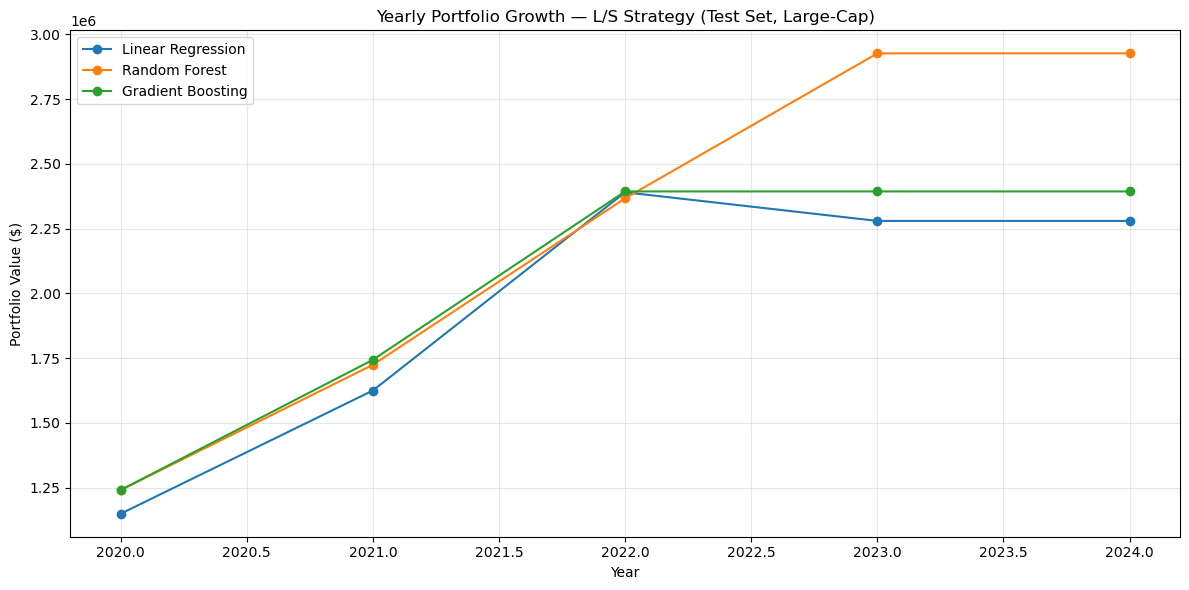

In [71]:
import matplotlib.pyplot as plt

# Put your tables into DataFrames (if not already)
lin = history_lin_test      # Linear Regression DF
rf  = history_rf_test       # Random Forest DF
gb  = history_gb_test       # Gradient Boosting DF

plt.figure(figsize=(12,6))

# Plot portfolio values for each model
plt.plot(lin["year"], lin["portfolio_value"], marker='o', label="Linear Regression")
plt.plot(rf["year"],  rf["portfolio_value"],  marker='o', label="Random Forest")
plt.plot(gb["year"],  gb["portfolio_value"],  marker='o', label="Gradient Boosting")

plt.title("Yearly Portfolio Growth — L/S Strategy (Test Set, Large-Cap)")
plt.xlabel("Year")
plt.ylabel("Portfolio Value ($)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
import numpy as np
import pandas as pd

def build_positions_table(val_df, validation_years, model_resid_col, model_name="model", top_n=2):
    """
    Returns a tidy DataFrame with one row per position:

    columns: [
      'model', 'resid_col', 'ticker', 'cik', 'side',
      'entry_year', 'exit_year',
      'entry_date', 'exit_date',
      'entry_price', 'exit_price'
    ]
    """

    df = val_df.copy()
    df["year"] = df["period"].dt.year

    records = []

    for year in validation_years:
        entry_year = year
        exit_year = year + 1

        undervalued, overvalued = get_top_residuals_by_year(df, model_resid_col, entry_year, top_n=top_n)
        if undervalued is None or overvalued is None:
            continue

        # mark sides
        undervalued = undervalued.copy()
        overvalued = overvalued.copy()
        undervalued["side"] = "long"
        overvalued["side"] = "short"

        picks = pd.concat([undervalued, overvalued], ignore_index=True)

        # next-year data for exits
        next_year_df = df[df["year"] == exit_year].dropna(subset=["close"]).copy()
        if next_year_df.empty:
            # no exit info for this year at all
            cik_to_exit = {}
        else:
            # sort so "first occurrence" is earliest in the year
            next_year_df = next_year_df.sort_values("period")

            # cik → (exit_date, exit_price)
            cik_to_exit = (
                next_year_df.drop_duplicates("cik", keep="first")
                            .set_index("cik")[["period", "close"]]
                            .to_dict(orient="index")
            )

        # now create one record per position
        for _, row in picks.iterrows():
            cik = row["cik"]
            tkr = row["ticker"]

            entry_date = row["period"]
            entry_price = float(row["close"])

            if cik in cik_to_exit:
                exit_date  = cik_to_exit[cik]["period"]
                exit_price = float(cik_to_exit[cik]["close"])
            else:
                exit_date  = pd.NaT
                exit_price = np.nan

            records.append({
                "model": model_name,
                "resid_col": model_resid_col,
                "ticker": tkr,
                "cik": cik,
                "side": row["side"],
                "entry_year": entry_year,
                "exit_year": exit_year,
                "entry_date": entry_date,
                "exit_date": exit_date,
                "entry_price": entry_price,
                "exit_price": exit_price,
            })

    if not records:
        return pd.DataFrame()

    positions = pd.DataFrame(records)

    # optional: add months + simple return
    positions["entry_month"] = positions["entry_date"].dt.month
    positions["exit_month"]  = positions["exit_date"].dt.month

    def pos_ret(r):
        if np.isnan(r["exit_price"]):
            return np.nan
        if r["side"] == "long":
            return r["exit_price"] / r["entry_price"] - 1.0
        else:
            return r["entry_price"] / r["exit_price"] - 1.0

    positions["return"] = positions.apply(pos_ret, axis=1)

    return positions


In [77]:
lin_positions = build_positions_table(
    val_df=test_df_large,           # or whatever df you use
    validation_years=trade_years,   # [2019, 2020, ...]
    model_resid_col="resid_lin",
    model_name="Linear",
    top_n=2
)

rf_positions = build_positions_table(
    test_df_large, trade_years, "resid_rf", model_name="RandomForest", top_n=2
)

gb_positions = build_positions_table(
    test_df_large, trade_years, "resid_gb", model_name="GradientBoosting", top_n=2
)

print(lin_positions)
print(100*'-')
print(rf_positions)
print(100*'-')
print(gb_positions)

     model  resid_col ticker      cik   side  entry_year  exit_year  \
0   Linear  resid_lin   GERN   886744   long        2020       2021   
1   Linear  resid_lin   CRDF  1213037   long        2020       2021   
2   Linear  resid_lin   BINI  1499961  short        2020       2021   
3   Linear  resid_lin   ATDS  1068689  short        2020       2021   
4   Linear  resid_lin  ZOMDF  1684144   long        2021       2022   
5   Linear  resid_lin   AAPL   320193   long        2021       2022   
6   Linear  resid_lin   ADTX  1726711  short        2021       2022   
7   Linear  resid_lin   APVO  1671584  short        2021       2022   
8   Linear  resid_lin   AAPL   320193   long        2022       2023   
9   Linear  resid_lin   MSFT   789019   long        2022       2023   
10  Linear  resid_lin   ADTX  1726711  short        2022       2023   
11  Linear  resid_lin  LFLYD  1785592  short        2022       2023   
12  Linear  resid_lin    SYM  1837240   long        2023       2024   
13  Li

# Archived

## Markowitz Portfolio Construction

In [ ]:
import numpy as np
import pandas as pd

# Start from full feature df
df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year

# Market cap at price_date
df_feat["mcap"] = df_feat["close"] * df_feat["CommonSharesOutstanding"]

# Large-cap filter: > 300M
mcap_threshold = 300_000_000
df_large = df_feat[df_feat["mcap"] > mcap_threshold].copy()

# --- Compute 1-year forward returns for large caps ---

# Keep only necessary columns
price_cols = df_large[["cik", "ticker", "year", "close"]].copy()

# Next-year close per cik
next_year = price_cols.copy()
next_year["year"] = next_year["year"] - 1   # shift year so we can merge t with t+1
next_year = next_year.rename(columns={"close": "next_close"})

# Merge to align year t with year t+1 close
returns_df = price_cols.merge(
    next_year[["cik", "year", "next_close"]],
    on=["cik", "year"],
    how="left"
)

# Forward simple return
returns_df["fwd_return"] = (returns_df["next_close"] - returns_df["close"]) / returns_df["close"]

# Keep only years where forward return is defined (i.e., we have next year's price)
returns_df = returns_df.dropna(subset=["fwd_return"])

In [ ]:
# Restrict validation df to large-cap only
val_df_large = val_df.copy()
val_df_large["mcap"] = val_df_large["close"] * val_df_large["CommonSharesOutstanding"]
val_df_large = val_df_large[val_df_large["mcap"] > mcap_threshold].copy()

val_df_large["year"] = val_df_large["period"].dt.year

# Choose how many BUY picks per year
TOP_K = 5

buy_universe = []

for yr in [2019, 2020]:
    year_slice = val_df_large[val_df_large["year"] == yr]
    # More negative residual = more undervalued
    top_buy = year_slice.sort_values("resid_gb").head(TOP_K)
    buy_universe.append(top_buy[["cik", "ticker"]])

buy_universe = pd.concat(buy_universe).drop_duplicates().reset_index(drop=True)
print("BUY universe (GB, large-cap):")
print(buy_universe)


In [ ]:
# Merge to get forward returns for BUY universe
buy_returns = returns_df.merge(
    buy_universe,
    on=["cik", "ticker"],
    how="inner"
)

# Keep only validation years
buy_returns = buy_returns[buy_returns["year"].isin([2019, 2020])].copy()

# Pivot to Year x Ticker matrix
R = buy_returns.pivot_table(
    index="year",
    columns="ticker",
    values="fwd_return"
)

print("Return matrix R (rows: years, cols: tickers):")
print(R)

In [ ]:
R = R.dropna(axis=1, how="any")  # require both years have returns
print("After dropping incomplete columns, assets for Markowitz:", R.columns.tolist())

mu = R.mean(axis=0).values        # expected returns (mean over years)
Sigma = R.cov().values            # covariance matrix (NxN)
tickers_m = R.columns.tolist()
N = len(tickers_m)
print("N assets in Markowitz universe:", N)


In [ ]:
import numpy as np

ones = np.ones(N)

# Unconstrained min-variance solution: w ∝ Σ^{-1} 1
Sigma_inv = np.linalg.pinv(Sigma)
w_raw = Sigma_inv @ ones
w_raw = w_raw / (ones @ w_raw)   # normalize to sum to 1

# Enforce long-only by clipping negatives and renormalising
w_long_only = np.clip(w_raw, 0, None)
if w_long_only.sum() == 0:
    # fallback: equal weight if everything got clipped
    w_long_only = np.ones(N) / N
else:
    w_long_only = w_long_only / w_long_only.sum()

print("\nMarkowitz long-only weights:")
for t, w in zip(tickers_m, w_long_only):
    print(f"{t}: {w:.3f}")

In [ ]:
# Portfolio returns per year
port_ret_marko = R.values @ w_long_only           # (2, N) @ (N,) -> (2,)
w_eq = np.ones(N) / N
port_ret_eq = R.values @ w_eq

results = pd.DataFrame({
    "year": R.index,
    "ret_markowitz": port_ret_marko,
    "ret_equal_weight": port_ret_eq
})

results["value_markowitz"] = (1 + results["ret_markowitz"]).cumprod()
results["value_equal_weight"] = (1 + results["ret_equal_weight"]).cumprod()

print("\nMarkowitz vs Equal-Weight performance (starting at 1.0):")
print(results)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(results["year"], results["value_markowitz"], "o-", label="Markowitz (GB BUYs)")
plt.plot(results["year"], results["value_equal_weight"], "o--", label="Equal-Weight (GB BUYs)")
plt.xlabel("Year")
plt.ylabel("Portfolio Value (starting at 1.0)")
plt.title("Markowitz vs Equal-Weight on Large-Cap GB BUYs (2019–2020)")
plt.legend()
plt.tight_layout()
plt.show()

## Star Companies (ARCHIVED)

In [ ]:
df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year

full_history_years = set(range(2014, 2025))   # 2014–2024
pnl_years         = {2019, 2020, 2021}        # years used for entry/exit

# 1) For each cik, what years does it appear in (regardless of price)?
years_by_cik_all = (
    df_feat.groupby("cik")["year"]
           .agg(lambda s: set(s.unique()))
)

# 2) For each cik, what years does it have a valid close price in?
years_by_cik_with_price = (
    df_feat.dropna(subset=["close"])
           .groupby("cik")["year"]
           .agg(lambda s: set(s.unique()))
)

# Align indexes
combined_index = years_by_cik_all.index.union(years_by_cik_with_price.index)

years_by_cik_all = years_by_cik_all.reindex(combined_index, fill_value=set())
years_by_cik_with_price = years_by_cik_with_price.reindex(combined_index, fill_value=set())

def is_star(cik):
    yrs_all   = years_by_cik_all.loc[cik]
    yrs_price = years_by_cik_with_price.loc[cik]
    has_full_history = full_history_years.issubset(yrs_all)
    has_all_pnl_years = pnl_years.issubset(yrs_price)
    return has_full_history and has_all_pnl_years

star_mask = pd.Series(combined_index).apply(is_star)
star_mask.index = combined_index

star_df = star_mask.astype(int).rename("star").to_frame()

# Merge back
df_feat = df_feat.merge(star_df, on="cik", how="left")
df     = df.merge(star_df, on="cik", how="left")

In [ ]:
# How many STAR companies?
n_star_companies = int(star_df["star"].sum())
print("Number of STAR companies:", n_star_companies)

# (Optional) quick peek at first few STAR CIKs
print(star_df[star_df["star"] == 1].head())


In [ ]:
# Merge STAR info onto validation dataframe (by cik)
val_df = val_df.merge(star_df, on="cik", how="left")

# Replace any missing star (NaN) with 0, then cast to int
val_df["star"] = val_df["star"].fillna(0).astype(int)

# Build STAR-only validation dataframe
val_df_star = val_df[val_df["star"] == 1].copy()

print("Total validation rows (ALL):", len(val_df))
print("Total validation rows (STAR):", len(val_df_star))
print("Unique STAR ciks in validation:", val_df_star["cik"].nunique())


In [ ]:
validation_years = [2019, 2020]

history_lin_star = run_portfolio_simulation(val_df_star, validation_years, "resid_lin")
history_rf_star  = run_portfolio_simulation(val_df_star, validation_years, "resid_rf")
history_gb_star  = run_portfolio_simulation(val_df_star, validation_years, "resid_gb")

print("\n=== STAR ONLY — Linear Regression Portfolio ===")
print(history_lin_star)

print("\n=== STAR ONLY — Random Forest Portfolio ===")
print(history_rf_star)

print("\n=== STAR ONLY — Gradient Boosting Portfolio (Primary) ===")
print(history_gb_star)


### Compare all versus star

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

# ALL companies
plt.plot(history_gb["year"], history_gb["portfolio_value"], 'o-', label="GB (ALL)")
plt.plot(history_rf["year"], history_rf["portfolio_value"], 'o-', label="RF (ALL)")
plt.plot(history_lin["year"], history_lin["portfolio_value"], 'o-', label="Lin (ALL)")

# STAR-only
plt.plot(history_gb_star["year"], history_gb_star["portfolio_value"], 'o--', label="GB (STAR)")
plt.plot(history_rf_star["year"], history_rf_star["portfolio_value"], 'o--', label="RF (STAR)")
plt.plot(history_lin_star["year"], history_lin_star["portfolio_value"], 'o--', label="Lin (STAR)")

plt.legend()
plt.title("Portfolio Values — ALL vs STAR (2019–2020)")
plt.xlabel("Year")
plt.ylabel("Portfolio Value ($)")
plt.show()